# Amazon SageMaker Asynchronous Inference

In [1]:
# !pip install -U sagemaker --quiet
# !pip install -U boto3 --quiet
# !pip install -U awscli --quiet

```
1. ./build_and_push_to_ecr.sh
2. docker run --name controlserve --rm -it --gpus all controlnet serve
3. (echo -n '{"email": "fra.pochetti@gmail.com", "s3_location": "fra.pochetti_at_gmail.com/2023/5/5/5/5/output2", "img_data": "'; base64 pytorch.png; echo '"}') | curl -H "Content-Type: application/json" -d @-  http://172.17.0.2:8080/invocations
4. (echo -n '{"email": "fra.pochetti@gmail.com", "s3_location": "fra.pochetti_at_gmail.com/2023/5/5/5/5/output5", "img_id": "s3://visualneurons.com-logos/franco.medinna_at_gmail.com/Entrega_AI_10.png"}') | curl -H "Content-Type: application/json" -d @-  http://172.17.0.2:8080/invocations
```

### Random tests

visualneurons.com-logos sparsamu_at_amazon.com/Picture2.png


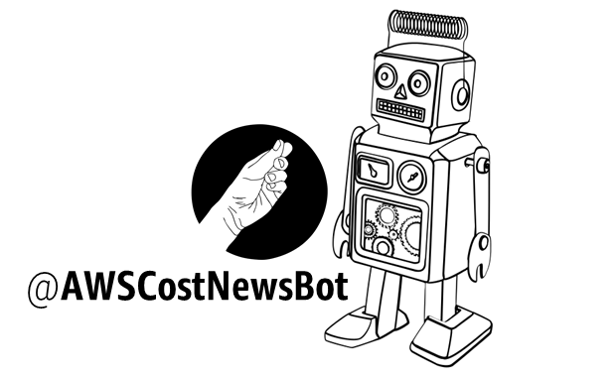

In [9]:
def rgba2rgb(rgba, background=(255,255,255)):
    row, col, ch = rgba.shape

    if ch == 3:
        return rgba

    assert ch == 4, 'RGBA image has 4 channels.'

    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]

    a = np.asarray( a, dtype='float32' ) / 255.0

    R, G, B = background

    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B

    return np.asarray(rgb, dtype='uint8')

def HWC3(x):
    assert x.dtype == np.uint8
    if x.ndim == 2:
        x = x[:, :, None]
    assert x.ndim == 3
    H, W, C = x.shape
    assert C == 1 or C == 3 or C == 4
    if C == 3:
        return x
    if C == 1:
        return np.concatenate([x, x, x], axis=2)
    if C == 4:
        color = x[:, :, 0:3].astype(np.float32)
        alpha = x[:, :, 3:4].astype(np.float32) / 255.0
        y = color * alpha + 255.0 * (1.0 - alpha)
        y = y.clip(0, 255).astype(np.uint8)
        return y


def resize_image(input_image, resolution):
    H, W, C = input_image.shape
    H = float(H)
    W = float(W)
    k = float(resolution) / max(H, W)
    H *= k
    W *= k
    H = int(np.round(H / 64.0)) * 64
    W = int(np.round(W / 64.0)) * 64
    img = cv2.resize(input_image, (W, H), interpolation=cv2.INTER_LANCZOS4 if k > 1 else cv2.INTER_AREA)
    return img

import cv2
import numpy as np
from PIL import Image, ImageOps
import urllib, boto3, io

s3_url = "s3://visualneurons.com-logos/sparsamu_at_amazon.com/Picture2.png"
parsed_url = urllib.parse.urlparse(s3_url)
bucket = parsed_url.netloc
key = parsed_url.path[1:]
print(bucket, key)

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=key)
img = Image.open(io.BytesIO(obj['Body'].read())).convert('RGBA')
img = ImageOps.exif_transpose(img)
img#.convert('RGB')
# img = np.array(img)
# print(img.shape)

# # img = cv2.imread("./images/testlogo.jpg", cv2.IMREAD_UNCHANGED)
# # print(img.shape)
# img = rgba2rgb(img)
# print(img.shape)

# img = resize_image(img, 768)
# print(img.shape)

# Image.fromarray(img)


### Deployment

In [4]:
import sagemaker
import boto3
from time import gmtime, strftime
from datetime import datetime

region_name = "eu-west-1"
boto_session=boto3.Session(region_name=region_name)
sm_session = sagemaker.Session(boto_session=boto_session)
sm_client = boto_session.client("sagemaker")
sm_runtime = boto_session.client("sagemaker-runtime")
S3 = boto3.client('s3')
autoscaling = boto3.client("application-autoscaling", region_name=region_name)  # Common class representing Application Auto Scaling for SageMaker amongst other services

Specify your IAM role. Go the AWS IAM console (https://console.aws.amazon.com/iam/home) and add the following policies to your IAM Role:

   * SageMakerFullAccessPolicy


   * (Optional) Amazon SNS access: Add `sns:Publish` on the topics you define. Apply this if you plan to use Amazon SNS to receive notifications.

```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "sns:Publish"
            ],
            "Effect": "Allow",
            "Resource": "arn:aws:sns:<aws-region>:<account-id>:<topic-name>"
        }
    ]
}
```

* (Optional) KMS decrypt, encrypt if your Amazon S3 bucket is encrypte.

Specify your SageMaker IAM Role (`sm_role`) and Amazon S3 bucket (`s3_bucket`). You can optionally use a default SageMaker Session IAM Role and Amazon S3 bucket. Make sure the role you use has the necessary permissions for SageMaker, Amazon S3, and optionally Amazon SNS.

In [5]:
sm_role = "arn:aws:iam::257446244580:role/sagemaker-icevision"
print(f"Using Role: {sm_role}")

Using Role: arn:aws:iam::257446244580:role/sagemaker-icevision


In [6]:
resource_name = "controlnet-logos"

suffix = "g5-RGBA"
model_name = f"{resource_name}-model-{suffix}"
endpoint_config_name = f"{resource_name}-endpoint-config-{suffix}"
endpoint_name = f"{resource_name}-endpoint"
resource_id = ("endpoint/" + endpoint_name + "/variant/" + "variant1") # for autoscaling purposes

sm_output_bucket = "visualneurons.com-logos-outputs"

In [7]:
create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=sm_role,
    PrimaryContainer={
        "Image": "257446244580.dkr.ecr.eu-west-1.amazonaws.com/custom-images:controlnet",
    },
)

print(f"Created Model: {create_model_response['ModelArn']}")

Created Model: arn:aws:sagemaker:eu-west-1:257446244580:model/controlnet-logos-model-g5-rgba


In [8]:
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g5.2xlarge",
            "InitialInstanceCount": 1,
        }
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            "S3OutputPath": f"s3://{sm_output_bucket}/sagemaker_endpoint_output",
            # Optionally specify Amazon SNS topics
            "NotificationConfig": {
            #"SuccessTopic": "arn:aws:sns:<aws-region>:<account-id>:<topic-name>",
            "ErrorTopic": "arn:aws:sns:eu-west-1:257446244580:ControlNetErrorTopic",
            }
        },
        "ClientConfig": {"MaxConcurrentInvocationsPerInstance": 1},
    },
)
print(f"Created EndpointConfig: {create_endpoint_config_response['EndpointConfigArn']}")

Created EndpointConfig: arn:aws:sagemaker:eu-west-1:257446244580:endpoint-config/controlnet-logos-endpoint-config-g5-rgba


In [6]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

Created Endpoint: arn:aws:sagemaker:eu-west-1:257446244580:endpoint/controlnet-logos-endpoint


Validate that the endpoint is created before invoking it:

In [7]:
waiter = sm_client.get_waiter("endpoint_in_service")
print("Waiting for endpoint to create...")
waiter.wait(EndpointName=endpoint_name)
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
print(f"Endpoint Status: {resp['EndpointStatus']}")

Waiting for endpoint to create...
Endpoint Status: InService


### Setup AutoScaling policy (Optional)

This section describes how to configure autoscaling on your asynchronous endpoint using Application Autoscaling. You need to first register your endpoint variant with Application Autoscaling, define a scaling policy, and then apply the scaling policy. In this configuration, we use a custom metric, `CustomizedMetricSpecification`, called `ApproximateBacklogSizePerInstance`. Please refer to the SageMaker Developer guide for a detailed list of metrics available with your asynchronous inference endpoint.

In [10]:
# Configure Autoscaling on asynchronous endpoint down to zero instances
response = autoscaling.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=0,
    MaxCapacity=2,
)

response = autoscaling.put_scaling_policy(
    PolicyName="Invocations-ScalingPolicy",
    ServiceNamespace="sagemaker",  # The namespace of the AWS service that provides the resource.
    ResourceId=resource_id,  # Endpoint name
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",  # SageMaker supports only Instance Count
    PolicyType="TargetTrackingScaling",  # 'StepScaling'|'TargetTrackingScaling'
    TargetTrackingScalingPolicyConfiguration={
        "TargetValue": 1.0,
        "CustomizedMetricSpecification": {
            "MetricName": "ApproximateBacklogSizePerInstance",
            "Namespace": "AWS/SageMaker",
            "Dimensions": [{"Name": "EndpointName", "Value": endpoint_name}],
            "Statistic": "Average",
        },
        "ScaleInCooldown": 600,  # The cooldown period helps you prevent your Auto Scaling group from launching or terminating
        # additional instances before the effects of previous activities are visible.
        # You can configure the length of time based on your instance startup time or other application needs.
        # ScaleInCooldown - The amount of time, in seconds, after a scale in activity completes before another scale in activity can start.
        "ScaleOutCooldown": 300  # ScaleOutCooldown - The amount of time, in seconds, after a scale out activity completes before another scale out activity can start.
        # 'DisableScaleIn': True|False - ndicates whether scale in by the target tracking policy is disabled.
        # If the value is true , scale in is disabled and the target tracking policy won't remove capacity from the scalable resource.
    },
)

In [11]:
response = autoscaling.put_scaling_policy(
    PolicyName="HasBacklogWithoutCapacity-ScalingPolicy",
    ServiceNamespace="sagemaker",  # The namespace of the service that provides the resource.
    ResourceId=resource_id,  # Endpoint name
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",  # SageMaker supports only Instance Count
    PolicyType="StepScaling",  # 'StepScaling' or 'TargetTrackingScaling'
    StepScalingPolicyConfiguration={
        "AdjustmentType": "ChangeInCapacity", # Specifies whether the ScalingAdjustment value in the StepAdjustment property is an absolute number or a percentage of the current capacity. 
        "MetricAggregationType": "Average", # The aggregation type for the CloudWatch metrics.
        "Cooldown": 300, # The amount of time, in seconds, to wait for a previous scaling activity to take effect. 
        "StepAdjustments": # A set of adjustments that enable you to scale based on the size of the alarm breach.
        [ 
            {
              "MetricIntervalLowerBound": 0,
              "ScalingAdjustment": 1
            }
          ]
    },    
)

In [12]:
response

{'PolicyARN': 'arn:aws:autoscaling:eu-west-1:257446244580:scalingPolicy:30e8b7ac-0b61-4a47-9d65-764d02eeccfb:resource/sagemaker/endpoint/controlnet-logos-endpoint/variant/variant1:policyName/HasBacklogWithoutCapacity-ScalingPolicy',
 'Alarms': [],
 'ResponseMetadata': {'RequestId': '94a406e0-fd59-4d89-b25c-40619d46895b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '94a406e0-fd59-4d89-b25c-40619d46895b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '243',
   'date': 'Sat, 13 May 2023 16:55:32 GMT'},
  'RetryAttempts': 0}}

In [13]:
cw_client = boto3.client("cloudwatch", region_name=region_name)

response = cw_client.put_metric_alarm(
    AlarmName="HasBacklogWithoutCapacity-ScalingPolicy",
    MetricName='HasBacklogWithoutCapacity',
    Namespace='AWS/SageMaker',
    Statistic='Average',
    EvaluationPeriods= 2,
    DatapointsToAlarm= 2,
    Threshold= 1,
    ComparisonOperator='GreaterThanOrEqualToThreshold',
    TreatMissingData='missing',
    Dimensions=[
        { 'Name':'EndpointName', 'Value':endpoint_name },
    ],
    Period= 60,
    AlarmActions=['arn:aws:autoscaling:eu-west-1:257446244580:scalingPolicy:30e8b7ac-0b61-4a47-9d65-764d02eeccfb:resource/sagemaker/endpoint/controlnet-logos-endpoint/variant/variant1:policyName/HasBacklogWithoutCapacity-ScalingPolicy']
)

### 2.1 Uploading the Request Payload <a id='upload'></a>

In [12]:
import base64, json

def upload_file(json_name):
    S3.upload_file(json_name, 
                   sm_output_bucket, 
                   f"tests/{json_name}",
                   ExtraArgs={"ContentType": "application/json"},)
    return f"s3://{sm_output_bucket}/tests/{json_name}"

def jsonify_image(img_local_path, json_name, s3_location):
    data = {'img_id': img_local_path}
    data["email"] = "fra.pochetti@gmail.com"
    data["s3_location"] = s3_location

    with open(img_local_path, "rb") as image_file:
        img_data = base64.b64encode(image_file.read())
        data["img_data"] = img_data.decode("utf-8")        
        image_file.close()

    with open(json_name, 'w', encoding='utf8') as f:
        json.dump(data, f, ensure_ascii=False)
        f.close()

In [13]:
jsonify_image("pytorch.png", "pytorch.json", "tests/fra3")
input_s3_location = upload_file("pytorch.json")
input_s3_location

's3://visualneurons.com-logos-outputs/tests/pytorch.json'

### 2.1 Invoke Endpoint   <a id='invoke-endpoint'></a>

Get inferences from the model hosted at your asynchronous endpoint with `InvokeEndpointAsync`. Specify the location of your inference data in the `InputLocation` field and the name of your endpoint for `EndpointName`. The response payload contains the output Amazon S3 location where the result will be placed. 

In [14]:
response = sm_runtime.invoke_endpoint_async(
    EndpointName=endpoint_name, InputLocation=input_s3_location
)
output_location = response["OutputLocation"]
print(f"OutputLocation: {output_location}")

OutputLocation: s3://visualneurons.com-logos-outputs/sagemaker_endpoint_output/80399913-883b-4ce9-aa9f-0e9f50eced93.out


In [18]:
!aws s3 cp $output_location output.out

download: s3://visualneurons.com-logos-outputs/sagemaker_endpoint_output/5ed0a06a-3c08-4920-a731-f14b8e7e46c5.out to ./output.out


In [20]:
# from io import BytesIO
# from PIL import Image

# # read out file
# with open('output.out', 'r') as f:
#     output = f.read()
#     f.close()

# img = base64.b64decode(output)
# Image.open(BytesIO(img)).convert('RGB')

### 2.2 Check Output Location <a id='check-output'></a>

Check the output location to see if the inference has been processed. We make multiple requests (beginning of the `while True` statement in the `get_output` function) every two seconds until there is an output of the inference request: 

In [21]:
# import urllib, time
# from botocore.exceptions import ClientError
# S3 = boto3.client('s3')


# def get_output(output_location):
#     output_url = urllib.parse.urlparse(output_location)
#     bucket = output_url.netloc
#     key = output_url.path[1:]

#     t_end = time.time() + 60 * 1
#     while time.time() < t_end:
#         try:
#             return S3.head_object(Bucket=bucket, Key=key) 
#             #sm_session.read_s3_file(bucket=output_url.netloc, key_prefix=output_url.path[1:])
#         except ClientError as e:
#             if e.response['Error']['Code'] == "404":
#                 print(f"Waiting for {output_location} to be available...")
#                 time.sleep(20)
#                 continue
#             raise

### 3. Clean up <a id='clean'></a>

If you enabled auto-scaling for your endpoint, ensure you deregister the endpoint as a scalable target before deleting the endpoint. To do this, run the following:

In [14]:
response = autoscaling.deregister_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
)

In [15]:
sm_client.delete_model(ModelName=model_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'dc26ad78-c705-4491-9139-bf35e4432ca2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'dc26ad78-c705-4491-9139-bf35e4432ca2',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sat, 13 May 2023 18:02:09 GMT'},
  'RetryAttempts': 0}}